In [1]:
import time
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

In [2]:
dt = torchvision.datasets.FashionMNIST("/home/mikewei/data/datasets", train=True, download=True, transform=transforms.ToTensor())
dv = torchvision.datasets.FashionMNIST("/home/mikewei/data/datasets", train=False, download=True)#, transform=transforms.ToTensor())
dv[0][0]

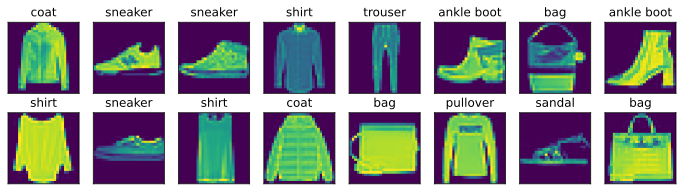

In [3]:
class FashionMNIST(d2l.DataModule):
    data_dir = "/home/mikewei/data/datasets"
    def __init__(self, batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        # 1 x 28 x 28 tensors
        self.train = torchvision.datasets.FashionMNIST(self.data_dir, train=True, download=True, transform=transforms.ToTensor())
        self.val = torchvision.datasets.FashionMNIST(self.data_dir, train=False, download=True, transform=transforms.ToTensor())
    def get_dataloader(self, train):
        return torch.utils.data.DataLoader(self.train if train else self.val, self.batch_size, 
                                           shuffle=train, num_workers=self.num_workers)
    def text_labels(self, indices):
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]
    def visualize(self, batch, nrows=1, ncols=8):
        X, y = batch
        labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

data = FashionMNIST()
data.visualize(next(iter(data.train_dataloader())), 2)

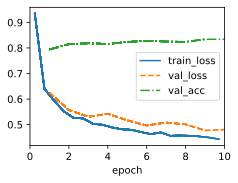

In [4]:
class SoftmaxRegression(d2l.Classifier):
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.LazyLinear(num_outputs))
    def forward(self, X):
        return self.net(X)
    def loss(self, Y_hat, Y):
        return torch.nn.functional.cross_entropy(Y_hat, Y)

data = FashionMNIST(256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

In [10]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens,lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = torch.nn.Sequential(torch.nn.Flatten(),
                                       torch.nn.LazyLinear(num_hiddens), torch.nn.ReLU(),
                                       torch.nn.LazyLinear(num_outputs))
model = MLP(10, 4096, 0.03)
trainer = d2l.Trainer(max_epochs=100, num_gpus=1)
trainer.fit(model, data)
model.board.data['val_acc'][-1], model.board.data['val_loss'][-1]

(Point(x=100.0, y=0.88447265625), Point(x=100.0, y=0.31901654973626137))

['sandal',
 'pullover',
 'sandal',
 'pullover',
 'shirt',
 't-shirt',
 'shirt',
 'shirt',
 't-shirt',
 'coat',
 'sneaker',
 'pullover',
 'shirt',
 'sneaker',
 'coat',
 'shirt']

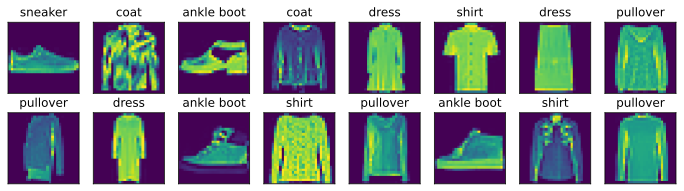

In [116]:
dl = data.val_dataloader()
X, y = next(iter(dl))
gpu = torch.device('cuda:0')
y_hat = model.forward(X.to(gpu)).to('cpu:0')
wrong_indices = (torch.argmax(y_hat, -1) != y)
X_wrong, y_hat_wrong, y_wrong = X[wrong_indices], y_hat[wrong_indices], y[wrong_indices]

data.visualize((X_wrong, y_wrong), 2)
data.text_labels(torch.argmax(y_hat_wrong, -1))[:16]

In [11]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_ouputs, num_hiddens_1, num_hiddens_2, dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = torch.nn.Sequential(
            torch.nn.Flatten(), torch.nn.LazyLinear(num_hiddens_1), torch.nn.ReLU(),
            torch.nn.Dropout(dropout_1), torch.nn.LazyLinear(num_hiddens_2), torch.nn.ReLU(),
            torch.nn.Dropout(dropout_2), torch.nn.LazyLinear(num_ouputs))
model = DropoutMLP(10, 256, 256, 0.5, 0.5, 0.1)
trainer = d2l.Trainer(max_epochs=100, num_gpus=1)
trainer.fit(model, data)
model.board.data['val_acc'][-1], model.board.data['val_loss'][-1]

(Point(x=100.0, y=0.89677734375), Point(x=100.0, y=0.30555957201868295))